# Classifying Palmer Penguins
## Kate Kenny 
### CS 0451

In this blog post, we will explore how different models can be used to classify species of penguins in the Palmer Penguin data set and visualize both our results and some of the decisions that went into the models. 

### Importing Training Data and Exploring Trends
First, let's load our training data into a pandas dataframe and prepare it to be analyzed. Then, we will explore some general trends to see what features could be useful to use in predictions and what kinds of models could be effective to classify the penguin species.

In [25]:
import pandas as pd

train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

#Prepare Data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

X_train


,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
1,45.1,14.5,215.0,5000.0,7.63220,-25.46569,1,0,0,1,0,1,1,0
2,41.4,18.5,202.0,3875.0,9.59462,-25.42621,0,0,1,1,0,1,0,1
3,39.0,18.7,185.0,3650.0,9.22033,-26.03442,0,1,0,1,0,1,0,1
4,50.6,19.4,193.0,3800.0,9.28153,-24.97134,0,1,0,1,1,0,0,1
5,33.1,16.1,178.0,2900.0,9.04218,-26.15775,0,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,41.1,17.5,190.0,3900.0,8.94365,-26.06943,0,1,0,1,0,1,0,1
270,45.4,14.6,211.0,4800.0,8.24515,-25.46782,1,0,0,1,0,1,1,0
271,36.2,17.2,187.0,3150.0,9.04296,-26.19444,0,0,1,1,1,0,1,0
272,50.0,15.9,224.0,5350.0,8.20042,-26.39677,1,0,0,1,0,1,0,1


### Exploring and Visualizing the Training Data

Below is a scatterplot of penguin body mass compared to flipper length. The points in this plot are colored by species, as seen in the legend. This plot highlights that there seems to be some trends in body mass and flipper length by species but the Adelie and Chinstrap penguins are quite similar while the Gentoo penguins have higher body mass and flipper length. This could indicate that these features could be very good at predicting whether or not a penguin is Gentoo or not, but for the model to be effective we would need some other features to differentiate between the other two species. 

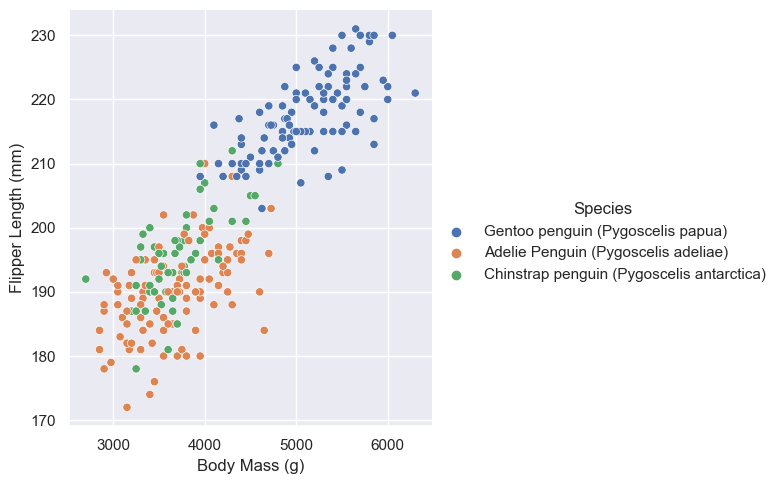

In [26]:
import seaborn as sns

sns.set_theme()

sns.relplot(data = train, 
           x = "Body Mass (g)", 
           y = "Flipper Length (mm)", 
           hue = "Species")

### Penguin population by species and Island
Next, let's consider the below table which displays the number of penguines on each island by species. This is an interesting category to examine since two of the penguin species (Gentoo and Chinstrap) were only recorded on one island each while Adelie penguins were found on all three. This could be relevant to our prediction models since it could be easy to eliminate possible species when making predictions based on the island on which they were found. This leads me to believe Island will be a useful qualitative feature for our model.

In [27]:
train.groupby(["Species", "Island"])[["Species"]].count()

Species
Species                                   Island            
Adelie Penguin (Pygoscelis adeliae)       Biscoe          35
                                          Dream           41
                                          Torgersen       42
Chinstrap penguin (Pygoscelis antarctica) Dream           56
Gentoo penguin (Pygoscelis papua)         Biscoe         101

### Choosing features and models

First, we want to select features that will lead to the best possible predictions from our model. To do this, we can use the Scikit Learn function SelectKBest which returns the specified number (k) of features that will result in the best prediction. 

So, below the code selects the best two quantitative and one qualitative feature to use in the modelling process later. 

In [28]:

#choose features and do cross validation NEED CROSS VALIDATION STILL

from itertools import combinations
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


all_qual_cols = ["Clutch Completion_No", "Clutch Completion_Yes", "Sex_FEMALE", "Sex_MALE", "Island_Biscoe", "Island_Dream", "Island_Torgersen"]
all_quant_cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]

LR = LogisticRegression()
col_scores = []

#create list of feature possibilities and their avg scores from cross validation 
for qual in all_qual_cols: 
  qual_cols = [col for col in X_train.columns if qual in col ]
  for pair in combinations(all_quant_cols, 2):
    cols = qual_cols + list(pair) 
    cv_scores = cross_val_score(LR, X_train[cols], y_train, cv = 5)
    score_avg = cv_scores.mean()
    col_scores.append((cols, score_avg))
    
#select the features with the highest score from list 
compare = 0
index = 0 
for i in range(len(col_scores)): 
    if col_scores[i][1] > compare: 
        index = i
        compare = col_scores[i][1]

selected_features = col_scores[index][0]
print(selected_features)


/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

['Island_Dream', 'Culmen Length (mm)', 'Culmen Depth (mm)']


/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

### Using the Selected Features
Now we can use the columns selected above to run a logistic regression model on the training data. The code above indicates that the best features to train our model on are Island, Culmen Length, and Culmen Depth. Now, let's look at how a variety of models score on the training data using these features. 

# Model Choices
### Logistic Regression

/Users/katekenny/opt/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<bound method ClassifierMixin.score of LogisticRegression()>


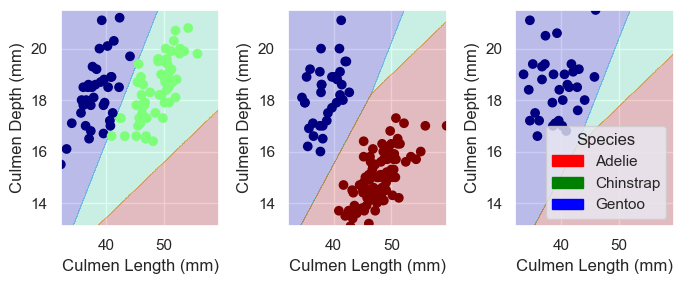

In [39]:
#Trying Different Models and Plotting decision regions
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import numpy as np
from mlxtend.plotting import plot_decision_regions


from matplotlib.patches import Patch

def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()


    
cols = ["Culmen Length (mm)", "Culmen Depth (mm)", "Island_Dream", "Island_Biscoe", "Island_Torgersen"]

LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

qual_features = ["Island_Biscoe", "Island_Dream", "Island_Torgersen"]
plot_regions(LR, X_train[cols], y_train)


### Decision Tree Classifier

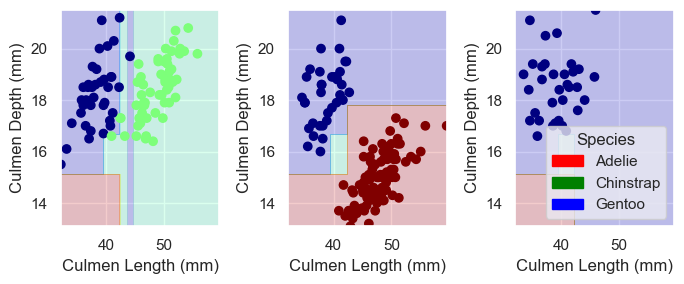

In [40]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(max_depth = 7)
DT.fit(X_train[cols], y_train)

plot_regions(DT, X_train[cols], y_train)



This model achhieves a training accuracy score of 1, however from the plots alone it is clear that there is some overfitting occurring to achieve the perfect accuracy score. As a result, even though this model has the "best' training score, it will likely not be the best model to make predictions on new data. 

### Support Vector Machine

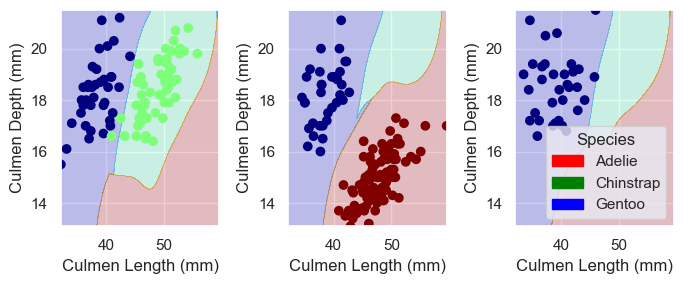

In [42]:
from sklearn.svm import SVC 

#NEED to cross validate to find gamma here 

sv = SVC(kernel="rbf", gamma = 0.1)
sv.fit(X_train[cols], y_train)

plot_regions(sv, X_train[cols], y_train)


### Testing the models

Now that we have trained a variety of models, we can score them on test data that the models have not yet seen. 

In [49]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)
print("Logistic Regression Score: ") 
print(LR.score(X_test[cols], y_test))
print("Decision Tree Score: ") 
print(DT.score(X_test[cols], y_test))
print("Support Vector Machine Score: ")
print(sv.score(X_test[cols], y_test))



Logistic Regression Score: 
1.0
Decision Tree Score: 
0.9852941176470589
Support Vector Machine Score: 
0.9558823529411765


### Results and discussions
From the results above, we can see that each of the three models considered and trained performed well with scores above .95. The model that performed the best on the test data was Logistic Regression, which had a perfect score of 1.0. S